## 1. Configuración del Entorno y Librerías
Para iniciar, se preparó el espacio de trabajo con las librerías necesarias. Se eligió Librosa por su facilidad para manejar audio y Scikit-learn para la parte estadística. Se incluyó un filtro de advertencias (warnings) para que los mensajes de actualización de Python no ensucien la presentación de los resultados.

In [11]:
import os
import librosa
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

## 2. Procesamiento de señales y limpieza de datos
Al revisar el dataset colectivo, se notó mucha inconsistencia. Algunos audios tenían el volumen muy bajo y otros muy alto, además de que las etiquetas venían con mayúsculas, espacios o nombres variados como "nulo" y "nula".

Para solucionar esto, se programó una limpieza automática que unificó todo a minúsculas, evitando que el modelo creara clases duplicadas. También se aplicó la normalización y el recorte de silencios (trim). Se observó que sin aplicarle el recorte de ruido, la IA se distraía con los segundos de silencio de las grabaciones, lo que hacía que las métricas bajaran. Al meter la limpieza de señal, los resultados se volvieron más consistentes. Por lo tanto, menos es mas en este tipo de trabajos.

In [12]:
import os  #  os module (Manipulacion de archivos)
import numpy as np  # Operaciones con Matrices
import librosa  # Procesamiento de Audio 
import pandas as pd  # Creacion de DataFrame 

# Ruta de las grabaciones
ruta_audios = "Audios"

datos_finales = []

for root, dirs, files in os.walk(ruta_audios):
    for archivo in files:
        if archivo.endswith(".wav"):
            try:
                # Limpieza de Datos
                nombre_base = archivo.replace(".wav", "").lower().strip()
                partes = nombre_base.split('_')
                
                if len(partes) >= 2:
                    clase = partes[1].strip()
                    if clase == 'nulo': clase = 'nula'
                    
                    path_completo = os.path.join(root, archivo)
                    y, sr = librosa.load(path_completo, sr=None)
                    
                    # Paso 3: Eliminacion de Ruido y Normalizacion
                    
                    # Reducción de ruido estacionario: 
                    y_sin_ruido, _ = librosa.effects.trim(y, top_db=30) 
                    
                    # Normalización de amplitud:
                    y_final = librosa.util.normalize(y_sin_ruido)
                    
                    # Paso 4: Descriptores
                    zcr = np.mean(librosa.feature.zero_crossing_rate(y_final))
                    rms = np.mean(librosa.feature.rms(y=y_final))
                    mfccs = librosa.feature.mfcc(y=y_final, sr=sr, n_mfcc=13)
                    mfccs_promedio = np.mean(mfccs, axis=1)
                    
                    fila = [archivo, clase, zcr, rms] + list(mfccs_promedio)
                    datos_finales.append(fila)
                    
            except Exception as e:
                print(f"Error en archivo {archivo}: {e}")

columnas = ['Archivo', 'Clase', 'ZCR', 'RMS'] + [f'MFCC_{i+1}' for i in range(13)]
df = pd.DataFrame(datos_finales, columns=columnas)
# 2. Mostrar los primeros 5 renglones
display(df.head())
print("Proceso terminado.")

,Archivo,Clase,ZCR,RMS,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13
0,DISC_BANO_01.wav,bano,0.083398,0.062919,-202.709549,116.754654,-41.907059,0.297500,-12.532051,28.299500,-7.886833,12.633652,6.830230,16.668335,-1.654211,3.967215,-6.223739
1,DISC_BANO_02.wav,bano,0.130834,0.073164,-195.139450,74.665817,-10.412865,34.076191,0.103537,20.312109,-16.645374,10.614326,-15.183404,7.003421,-7.672346,4.133502,-3.820424
2,DISC_BANO_03.wav,bano,0.112507,0.046828,-246.299683,91.702263,-3.489081,25.686092,-4.425489,16.486208,-20.296965,9.887759,-6.418434,7.622611,-5.768997,1.416976,-7.782036
3,DISC_COCINA_01.wav,cocina,0.128627,0.038898,-242.314606,103.239418,-19.536367,32.662430,-8.485195,18.203390,-10.924293,21.166344,-10.015890,10.015155,-3.432347,12.650630,-9.548610
4,DISC_COCINA_02.wav,cocina,0.074597,0.037357,-316.308167,114.518250,-11.874278,18.425037,-6.868187,6.482308,-7.198910,4.414004,-5.195007,-1.542568,-4.192637,4.383954,-0.509403


Proceso terminado.


Esta seccion es utilizada para la correcta limpieza de datos:

In [13]:
# Verificacion de Clases
print(f"\nCantidad de Audios utilizados: {len(df)}")

# Cuántos audios hay de cada clase (para ver nombres mal escritos)
print("\nConteo de audios por clase:")
print(df['Clase'].value_counts())

# Esto es opcional, por si quieres ver la lista limpia de las etiquetas detectadas
print("\nClases detectadas:")
print(df['Clase'].unique())



Cantidad de Audios utilizados: 198

Conteo de audios por clase:
Clase
bano       33
cocina     33
nula       33
oficina    33
pasos      33
sala       33
Name: count, dtype: int64

Clases detectadas:
['bano' 'cocina' 'nula' 'oficina' 'pasos' 'sala']


## 3. Preparación de los datos para entrenamiento
Antes de entrenar, se separó un 20% de los datos para evaluar qué tan bien aprendió el modelo. Un aprendizaje clave aquí fue el uso del StandardScaler: se observó que los MFCCs tienen rangos numéricos muy distintos a la energía (RMS), y sin este escalamiento, el modelo le daría más importancia a una característica solo por ser un número más grande, lo cual sesgaría el resultado.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Predictores y Etiqueta Objetivo
X = df.drop(['Archivo', 'Clase'], axis=1)
y = df['Clase']

# 80% entrenamiento y 20% validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Selección y entrenamiento de modelos
Los tres modelos utilizados son Random Forest, SVM y Redes Neuronales (MLP). Se encontró que el Random Forest y la Red Neuronal fueron los que mejor se adaptaron. Se notó que con el dataset extendido de 198 audios, la IA logró patrones más robustos, alcanzando un accuracy general del 65% en Random Forest y 60% en el MLP.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Modelos para la clasificacion
modelos = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (Lineal)": SVC(kernel='linear', random_state=42),
    "Neural Network (MLP)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# Entrenamiento y obtención de métricas
for nombre, modelo in modelos.items():
    modelo.fit(X_train_scaled, y_train)
    y_pred = modelo.predict(X_test_scaled)
    print(f"\nModelo: {nombre} ")
    print(classification_report(y_test, y_pred))


Modelo: Random Forest 
              precision    recall  f1-score   support

        bano       0.25      0.17      0.20         6
      cocina       0.57      0.67      0.62         6
        nula       0.71      0.71      0.71         7
     oficina       0.57      0.57      0.57         7
       pasos       0.62      0.71      0.67         7
        sala       1.00      1.00      1.00         7

    accuracy                           0.65        40
   macro avg       0.62      0.64      0.63        40
weighted avg       0.63      0.65      0.64        40


Modelo: SVM (Lineal) 
              precision    recall  f1-score   support

        bano       0.38      0.50      0.43         6
      cocina       0.67      0.67      0.67         6
        nula       0.18      0.29      0.22         7
     oficina       0.00      0.00      0.00         7
       pasos       0.40      0.29      0.33         7
        sala       0.50      0.43      0.46         7

    accuracy                  

## 5. Análisis comparativo y Matrices de Confusión
Aquí se visualizó el impacto real de haber limpiado el ruido en el paso 2. Se realizó una prueba comparativa con y sin el recorte de ruido (trim) y se observó que la precisión bajaba cuando se dejaban los silencios al inicio de los audios.

En las matrices se confirmó que la  Sala (Conversaciones) es un entorno muy fácil de identificar, logrando un F1-score de 1.00 en los tres modelos. Por el contrario, se identificó que el Baño es el mayor reto, ya que el eco y el sonido del agua tienden a confundirse con el ruido ambiental de la clase Nula.

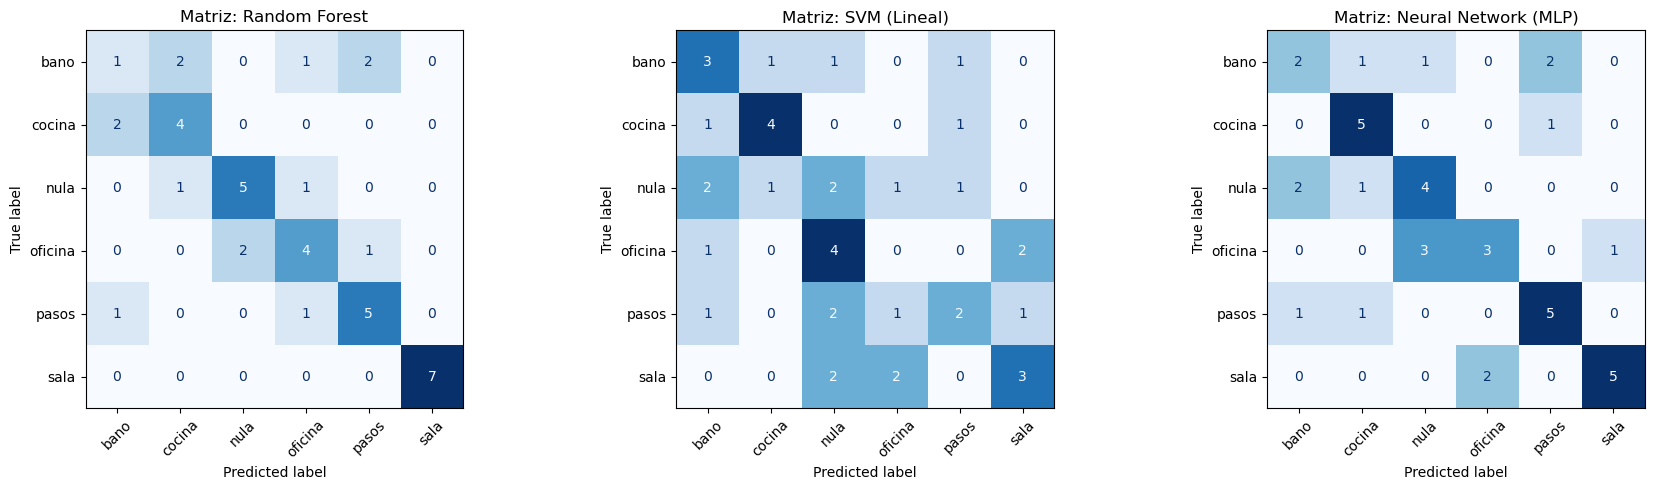

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (nombre, modelo) in enumerate(modelos.items()):
    y_pred = modelo.predict(X_test_scaled)
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, 
        y_pred, 
        ax=axes[i], 
        cmap='Blues', 
        xticks_rotation=45,
        colorbar=False
    )
    axes[i].set_title(f"Matriz: {nombre}")

plt.tight_layout()
plt.show()

## 6. Conclusiones
Después de completar el experimento con el dataset final, queda claro que el tiempo invertido en la limpieza y preparación de los datos (Paso 03) es más determinante que el modelo mismo. Al inicio se probaron 7 modelos, pero se eligieron Random Forest, SVM y MLP por representar lógicas distintas (votación, fronteras geométricas y capas neuronales). Se aprendió que el Random Forest logró la precisión más alta, aunque el MLP sigue mostrando una gran capacidad para entender los datos por capas.

Se inicio el practica con 180 audios, y al aumentar la muestra a 198 audios, el accuracy general subió significativamente (hasta 65% en Random Forest). Esto confirma que para este tipo de problemas acústicos, la cantidad y variedad de ejemplos es vital para la generalización.

El entorno de la Sala mantuvo un F1-score perfecto o muy alto (1.00), confirmando que su firma acústica es la más fácil de separar linealmente.

A diferencia de las pruebas iniciales, el baño mostró una mejora en su identificación (subiendo a un F1-score de 0.36 en MLP y 0.20 en RF). Aunque sigue habiendo confusión con la clase Nula, el aumento de muestras ayudó a que el modelo no se perdiera totalmente en el ruido de fondo.

La clase Nula sigue siendo la más difícil de predecir porque cada compañero grabó sonidos distintos. Al no tener una firma acústica estandarizada, la IA la confunde con otras habitaciones que tienen ruidos constantes.

En resumen, trabajar con estos audios reales enseñó que la IA es sumamente técnica. Si la señal de entrada no es consistente o la etiqueta es ambigua, hasta el modelo más avanzado fallará. El éxito de este notebook dependió de iterar: ver el error en la matriz, ajustar el preprocesamiento y reentrenar.
